<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%204%20/%20Tugas%20/%20PyTorch_IMDB_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
num_words = 30000
maxlen = 433

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Convert to tensor
x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)


In [4]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#RNN

In [5]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [8]:
model = RNNModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(20):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")


Epoch [1/20] Train Acc: 0.5938, Train Loss: 0.6552 | Test Acc: 0.5787, Test Loss: 0.6536
Epoch [2/20] Train Acc: 0.6474, Train Loss: 0.6147 | Test Acc: 0.5981, Test Loss: 0.6576
Epoch [3/20] Train Acc: 0.7086, Train Loss: 0.5640 | Test Acc: 0.6467, Test Loss: 0.6120
Epoch [4/20] Train Acc: 0.7576, Train Loss: 0.5031 | Test Acc: 0.6686, Test Loss: 0.5993
Epoch [5/20] Train Acc: 0.7904, Train Loss: 0.4623 | Test Acc: 0.7656, Test Loss: 0.5093
Epoch [6/20] Train Acc: 0.8120, Train Loss: 0.4222 | Test Acc: 0.7764, Test Loss: 0.5085
Epoch [7/20] Train Acc: 0.8354, Train Loss: 0.3861 | Test Acc: 0.7445, Test Loss: 0.5448
Epoch [8/20] Train Acc: 0.8485, Train Loss: 0.3622 | Test Acc: 0.7508, Test Loss: 0.5657
Epoch [9/20] Train Acc: 0.8744, Train Loss: 0.3173 | Test Acc: 0.7591, Test Loss: 0.5791
Epoch [10/20] Train Acc: 0.8880, Train Loss: 0.2855 | Test Acc: 0.7783, Test Loss: 0.5576
Epoch [11/20] Train Acc: 0.8989, Train Loss: 0.2685 | Test Acc: 0.7670, Test Loss: 0.5841
Epoch [12/20] Train

Final Training Accuracy: 0.9626
Final Testing Accuracy: 0.7652
Precision: 0.7599
Recall: 0.7754
F1 Squared: 0.5892
AUC: 0.8263


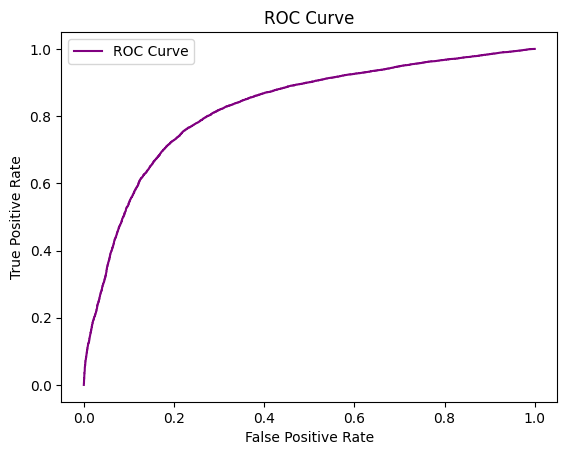

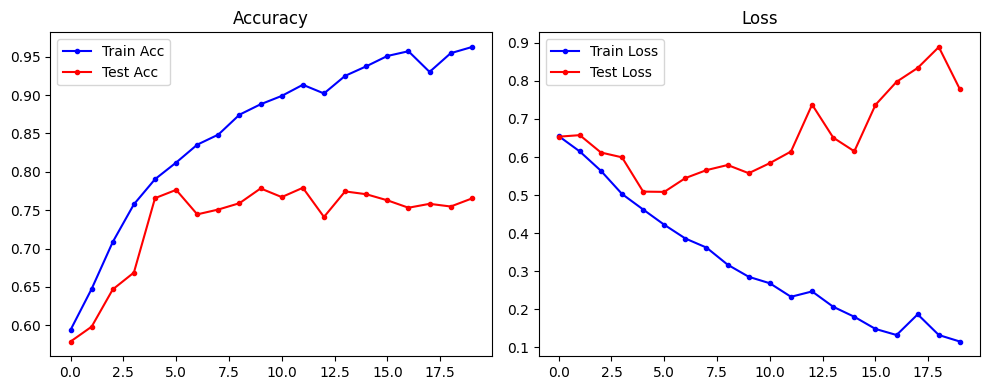

In [14]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='.', color='blue')
plt.plot(test_acc_list, label="Test Acc", marker='.', color='red')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='.', color='blue')
plt.plot(test_loss_list, label="Test Loss", marker='.', color='red')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


#LSTM

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [16]:
model = LSTMModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []


In [17]:
for epoch in range(20):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")



Epoch [1/20] Train Acc: 0.6699, Train Loss: 0.5960 | Test Acc: 0.7670, Test Loss: 0.4954
Epoch [2/20] Train Acc: 0.8040, Train Loss: 0.4363 | Test Acc: 0.7765, Test Loss: 0.4629
Epoch [3/20] Train Acc: 0.8477, Train Loss: 0.3628 | Test Acc: 0.8388, Test Loss: 0.3751
Epoch [4/20] Train Acc: 0.8962, Train Loss: 0.2598 | Test Acc: 0.8685, Test Loss: 0.3201
Epoch [5/20] Train Acc: 0.9210, Train Loss: 0.2065 | Test Acc: 0.8670, Test Loss: 0.3373
Epoch [6/20] Train Acc: 0.9344, Train Loss: 0.1727 | Test Acc: 0.8792, Test Loss: 0.3365
Epoch [7/20] Train Acc: 0.9586, Train Loss: 0.1195 | Test Acc: 0.8788, Test Loss: 0.3889
Epoch [8/20] Train Acc: 0.9722, Train Loss: 0.0840 | Test Acc: 0.8682, Test Loss: 0.4123
Epoch [9/20] Train Acc: 0.9816, Train Loss: 0.0561 | Test Acc: 0.8738, Test Loss: 0.4637
Epoch [10/20] Train Acc: 0.9868, Train Loss: 0.0404 | Test Acc: 0.8753, Test Loss: 0.4757
Epoch [11/20] Train Acc: 0.9903, Train Loss: 0.0295 | Test Acc: 0.8648, Test Loss: 0.6427
Epoch [12/20] Train

Final Training Accuracy: 0.9947
Final Testing Accuracy: 0.8691
Precision: 0.8844
Recall: 0.8492
F1 Squared: 0.7507
AUC: 0.9395


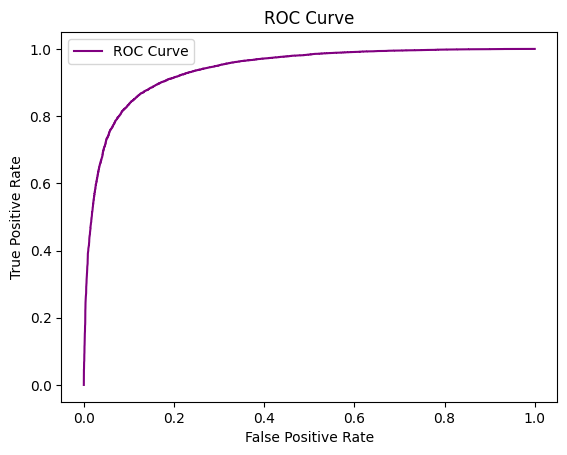

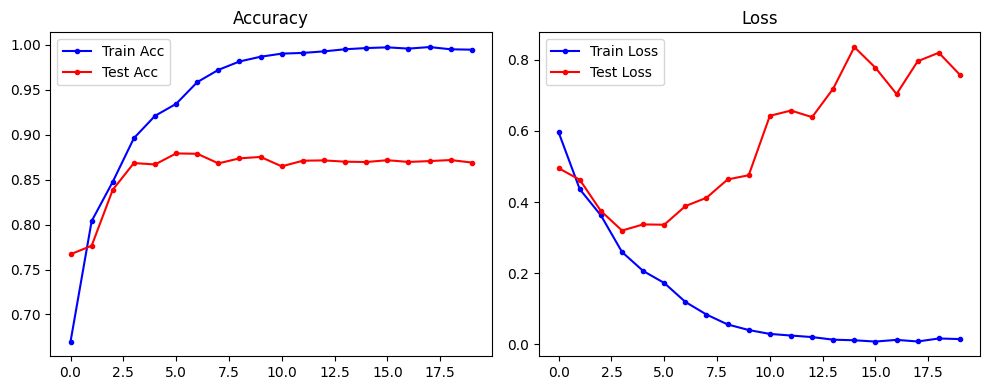

In [18]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='.', color='blue')
plt.plot(test_acc_list, label="Test Acc", marker='.', color='red')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='.', color='blue')
plt.plot(test_loss_list, label="Test Loss", marker='.', color='red')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


#GRU

In [19]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [20]:
model = GRUModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []


In [21]:
for epoch in range(20):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")


Epoch [1/20] Train Acc: 0.7030, Train Loss: 0.5598 | Test Acc: 0.8006, Test Loss: 0.4381
Epoch [2/20] Train Acc: 0.8413, Train Loss: 0.3767 | Test Acc: 0.8588, Test Loss: 0.3407
Epoch [3/20] Train Acc: 0.9018, Train Loss: 0.2514 | Test Acc: 0.8796, Test Loss: 0.2868
Epoch [4/20] Train Acc: 0.9338, Train Loss: 0.1801 | Test Acc: 0.8697, Test Loss: 0.3117
Epoch [5/20] Train Acc: 0.9546, Train Loss: 0.1261 | Test Acc: 0.8800, Test Loss: 0.3755
Epoch [6/20] Train Acc: 0.9726, Train Loss: 0.0794 | Test Acc: 0.8777, Test Loss: 0.3976
Epoch [7/20] Train Acc: 0.9828, Train Loss: 0.0511 | Test Acc: 0.8776, Test Loss: 0.4919
Epoch [8/20] Train Acc: 0.9884, Train Loss: 0.0371 | Test Acc: 0.8791, Test Loss: 0.5490
Epoch [9/20] Train Acc: 0.9890, Train Loss: 0.0324 | Test Acc: 0.8665, Test Loss: 0.5373
Epoch [10/20] Train Acc: 0.9941, Train Loss: 0.0193 | Test Acc: 0.8619, Test Loss: 0.6747
Epoch [11/20] Train Acc: 0.9934, Train Loss: 0.0201 | Test Acc: 0.8630, Test Loss: 0.7854
Epoch [12/20] Train

Final Training Accuracy: 0.9978
Final Testing Accuracy: 0.8726
Precision: 0.8998
Recall: 0.8385
F1 Squared: 0.7535
AUC: 0.9440


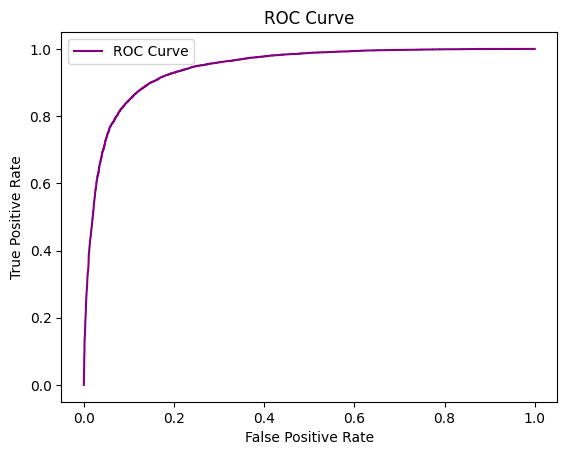

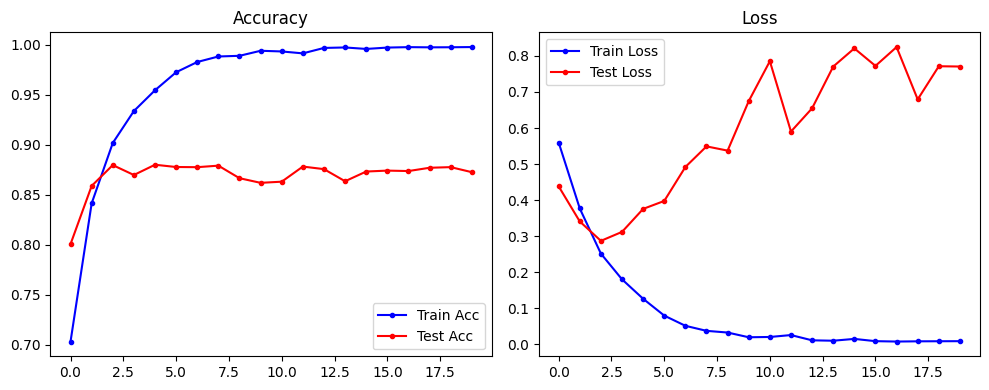

In [23]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='.', color='blue')
plt.plot(test_acc_list, label="Test Acc", marker='.', color='red')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='.', color='blue')
plt.plot(test_loss_list, label="Test Loss", marker='.', color='red')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


#Persamaan Matematika pada DL

---

##1. RNN

Model RNN mempertimbangkan urutan dengan memori internal:

$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$

- \($ h_t $\): Hidden state saat waktu \($ t $\)
- \($ x_t $\): Input saat waktu \($ t $\)
- \($ W_h, W_x $\): Bobot hidden dan input
- \($ b $\): Bias

---

##2. LSTM

LSTM memiliki mekanisme gate untuk menangani long-term dependency:

\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \quad \text{(forget gate)} \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \quad \text{(input gate)} \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \quad \text{(candidate state)} \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \quad \text{(cell state)} \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \quad \text{(output gate)} \\
h_t &= o_t * \tanh(C_t) \quad \text{(hidden state)}
\end{aligned}

---

##3. GRU

GRU adalah versi lebih sederhana dari LSTM:

\begin{aligned}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \quad \text{(update gate)} \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \quad \text{(reset gate)} \\
\tilde{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \quad \text{(candidate state)} \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t \quad \text{(new state)}
\end{aligned}

---

##4. Binary Cross-Entropy Loss

Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

- \($ y_i $\): Label sebenarnya (0 atau 1)
- \($ \hat{y}_i $\): Prediksi model

---

##5. Evaluasi Model


$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

$\text{Precision} = \frac{TP}{TP + FP}$

$
\text{Recall} = \frac{TP}{TP + FN}
$

$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$

$
F1^2 = (F1)^2
$

**AUC :** Luas di bawah kurva ROC yang menggambarkan trade-off antara TPR dan FPR.

**ROC Curve :** Grafik yang menunjukkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

---

